In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_csv('../data/raw/clinical_data_lung.zip')

In [3]:
df.columns

Index(['Age recode with <1 year olds and 90+',
       'Race recode (White, Black, Other)', 'Primary Site - labeled',
       'Histologic Type ICD-O-3', 'Grade Clinical (2018+)',
       'Grade Recode (thru 2017)',
       'Combined Summary Stage with Expanded Regional Codes (2004+)',
       'Derived EOD 2018 Stage Group Recode (2018+)',
       '7th Edition Stage Group Recode (2016-2017)',
       'Derived AJCC Stage Group, 7th ed (2010-2015)',
       'CS tumor size (2004-2015)', 'Tumor Size Summary (2016+)',
       'Survival months', 'Survival months flag',
       'Vital status recode (study cutoff used)',
       'SEER cause-specific death classification', 'Year of diagnosis',
       'Median household income inflation adj to 2023',
       'RX Summ--Surg Prim Site (1998+)', 'Radiation recode',
       'Chemotherapy recode (yes, no/unk)', 'Sex',
       'Rural-Urban Continuum Code', 'Reason no cancer-directed surgery',
       'Total number of in situ/malignant tumors for patient',
       'Tota

In [4]:
df.rename(columns={'Race recode (White, Black, Other)': 'Race', 'Rural-Urban Continuum Code': 'Rural Code',
                   'SEER cause-specific death classification': 'vital_status', 'Primary Site - labeled': 'Primary Site'}, inplace=True)

## Eliminar duplicados

In [5]:
df.duplicated().sum()

np.int64(4977)

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.columns

Index(['Age recode with <1 year olds and 90+', 'Race', 'Primary Site',
       'Histologic Type ICD-O-3', 'Grade Clinical (2018+)',
       'Grade Recode (thru 2017)',
       'Combined Summary Stage with Expanded Regional Codes (2004+)',
       'Derived EOD 2018 Stage Group Recode (2018+)',
       '7th Edition Stage Group Recode (2016-2017)',
       'Derived AJCC Stage Group, 7th ed (2010-2015)',
       'CS tumor size (2004-2015)', 'Tumor Size Summary (2016+)',
       'Survival months', 'Survival months flag',
       'Vital status recode (study cutoff used)', 'vital_status',
       'Year of diagnosis', 'Median household income inflation adj to 2023',
       'RX Summ--Surg Prim Site (1998+)', 'Radiation recode',
       'Chemotherapy recode (yes, no/unk)', 'Sex', 'Rural Code',
       'Reason no cancer-directed surgery',
       'Total number of in situ/malignant tumors for patient',
       'Total number of benign/borderline tumors for patient',
       'Sequence number', 'Type of Reporting S

In [8]:
columnas_strip = ['Age recode with <1 year olds and 90+', 'Race', 'Primary Site',
       'Histologic Type ICD-O-3', 'Grade Clinical (2018+)',
       'Grade Recode (thru 2017)',
       'Combined Summary Stage with Expanded Regional Codes (2004+)',
       'Derived EOD 2018 Stage Group Recode (2018+)',
       '7th Edition Stage Group Recode (2016-2017)',
       'Derived AJCC Stage Group, 7th ed (2010-2015)',
       'CS tumor size (2004-2015)', 'Tumor Size Summary (2016+)',
       'Survival months', 'Survival months flag',
       'Vital status recode (study cutoff used)', 'vital_status',
       'Year of diagnosis', 'Median household income inflation adj to 2023',
       'RX Summ--Surg Prim Site (1998+)', 'Radiation recode',
       'Chemotherapy recode (yes, no/unk)', 'Sex', 'Rural Code',
       'Reason no cancer-directed surgery',
       'Total number of in situ/malignant tumors for patient',
       'Total number of benign/borderline tumors for patient',
       'Sequence number', 'Type of Reporting Source']

# Aplicar strip SOLO a las columnas que son string / object
df[columnas_strip] = df[columnas_strip].apply(lambda x: x.str.strip() if x.dtype in ['object', 'string'] else x)

## Target `survival_months`

In [9]:
df["Survival months flag"].value_counts()

Survival months flag
Complete dates are available and there are more than 0 days of survival      514288
Not calculated because a Death Certificate Only or Autopsy Only case           8706
Incomplete dates are available and there cannot be zero days of follow-up      6452
Complete dates are available and there are 0 days of survival                  2058
Incomplete dates are available and there could be zero days of follow-up        937
Name: count, dtype: int64

In [10]:
df["Survival months"].unique()

array(['0059', '0027', '0000', '0052', '0012', '0014', '0005', '0016',
       '0040', '0010', '0009', '0001', '0020', '0003', '0002', '0021',
       '0025', '0130', '0007', '0013', '0060', '0017', '0111', '0033',
       '0004', '0090', '0037', '0062', '0024', '0008', '0006', '0076',
       '0075', '0034', '0098', '0050', '0053', '0015', '0094', '0038',
       '0078', '0026', '0128', '0125', 'Unknown', '0042', '0058', '0091',
       '0051', '0079', '0018', '0036', '0113', '0019', '0011', '0086',
       '0129', '0030', '0092', '0101', '0032', '0070', '0084', '0126',
       '0056', '0082', '0116', '0043', '0054', '0063', '0044', '0045',
       '0121', '0123', '0102', '0074', '0057', '0081', '0028', '0023',
       '0099', '0039', '0022', '0046', '0029', '0072', '0088', '0115',
       '0064', '0061', '0108', '0073', '0035', '0120', '0031', '0068',
       '0055', '0047', '0041', '0077', '0071', '0066', '0093', '0067',
       '0065', '0083', '0117', '0085', '0100', '0118', '0105', '0069',
   

In [11]:
# Ver de forma rápida cuántos hay de cada tipo en esa columna
print(df["Survival months"].value_counts().get("Unknown", 0))

8706


In [12]:
# 1. Definimos quiénes entran al modelo de excelencia
# Solo pacientes con fechas completas y vida mayor a 0
condicion_completa = 'Complete dates are available and there are more than 0 days of survival'
condicion_incompleta = 'Incomplete dates are available and there cannot be zero days of follow-up'

filtro_excelencia = df['Survival months flag'].isin([condicion_completa, condicion_incompleta])

# 2. Separamos los datasets
df = df[filtro_excelencia].copy()
df_excluidos = df[~filtro_excelencia].copy() # El ~ significa "lo que no cumple el filtro"

# df = df[df['Survival months'] != 'Unknown'].copy()

# 1. Aseguramos que sea entero
df['survival_months_int'] = pd.to_numeric(df['Survival months'], errors='coerce').fillna(0).astype(int)


C:\Users\Usuario\AppData\Local\Temp\ipykernel_18972\2464928762.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_excluidos = df[~filtro_excelencia].copy() # El ~ significa "lo que no cumple el filtro"


In [13]:

def agrupar_supervivencia_ajustado(meses):
    # Lógica de agrupación
    if meses <= 0:
        return 0
    elif 1 <= meses <= 56:
        return int(np.ceil(meses / 4.0) * 4)
    else:
        return 60

# 3. Aplicamos la transformación
df['Target_Meses'] = df['survival_months_int'].apply(agrupar_supervivencia_ajustado)

# 4. Verificación para confirmar los saltos que pediste
print("Rangos de supervivencia generados:")
print(sorted(df['Target_Meses'].unique()))

# Eliminar columnas antiguas
df = df.drop(["Survival months", "Survival months flag", "survival_months_int"], axis=1)

print("\nConteo por rango:")
print(df['Target_Meses'].value_counts().sort_index())


Rangos de supervivencia generados:
[np.int64(0), np.int64(4), np.int64(8), np.int64(12), np.int64(16), np.int64(20), np.int64(24), np.int64(28), np.int64(32), np.int64(36), np.int64(40), np.int64(44), np.int64(48), np.int64(52), np.int64(56), np.int64(60)]

Conteo por rango:
Target_Meses
0      56778
4     120246
8      62481
12     46127
16     33501
20     26322
24     20532
28     17182
32     13794
36     13242
40     11513
44     10491
48      9263
52      8308
56      7551
60     63409
Name: count, dtype: int64


In [14]:
# Ejemplo de pesos: Duplicar la importancia de registros con supervivencia >= 60 meses
# df['sample_weight'] = df['Target_Meses'].apply(lambda x: 5.0 if x >= 60 else 1.0)

In [15]:
# Pesos para priorizar extremos: < 12 meses y >= 20 meses
# df['sample_weight'] = df['Target_Meses'].apply(
#     lambda x: 5.0 if (x < 12 or x >= 60) else 1.0
# )

In [16]:
# df['sample_weight'] = df['Target_Meses'].apply(lambda x: 2.0 if x > 12 else 1.0)

## Variables 'Vital status'

In [17]:
df['vital_status'].value_counts()

vital_status
Dead (attributable to this cancer dx)    298925
Alive or dead of other cause             218151
Dead (missing/unknown COD)                 3664
Name: count, dtype: int64

In [18]:
# # 1. Creamos un filtro de 'Muerte por Cáncer' o 'Sigue Vivo'
# # Excluimos a los que murieron por causas ajenas para no confundir al modelo
# filtro_causa_especifica = (df['vital_status'] == 'Dead (attributable to this cancer dx)') | \
#                           (df['vital_status'] == 'Alive or dead of other cause')

# # Aplicamos el filtro para tener un dataframe puramente oncólogico
# df = df[filtro_causa_especifica].copy()

In [19]:
# Si alguien está vivo pero tiene pocos meses, es un caso de diagnóstico reciente
# Si alguien está muerto pero tiene 20 trimestres, es un éxito de supervivencia a largo plazo
print(df.groupby('Vital status recode (study cutoff used)')['Target_Meses'].mean())

Vital status recode (study cutoff used)
Alive    34.660731
Dead     14.469835
Name: Target_Meses, dtype: float64


In [20]:
# Se elimina las variasbles de 'respuesta'.
df = df.drop(["vital_status", "Vital status recode (study cutoff used)"], axis=1)

## Variable AGE

In [21]:
df["Age recode with <1 year olds and 90+"].value_counts()

Age recode with <1 year olds and 90+
70-74 years    94788
65-69 years    88776
75-79 years    82922
60-64 years    68105
80-84 years    58918
55-59 years    44717
85-89 years    32390
50-54 years    21652
90+ years      13466
45-49 years     8569
40-44 years     3426
35-39 years     1513
30-34 years      745
25-29 years      368
20-24 years      194
15-19 years       84
01-04 years       36
10-14 years       34
00 years          20
05-09 years       17
Name: count, dtype: int64

In [22]:
df = df[~df['Age recode with <1 year olds and 90+'].isin(['00 years', '01-04 years', '05-09 years', '10-14 years', '15-19 years', '20-24 years', '25-29 years', '30-34 years'])]

In [23]:
df["Age recode with <1 year olds and 90+"].value_counts()

Age recode with <1 year olds and 90+
70-74 years    94788
65-69 years    88776
75-79 years    82922
60-64 years    68105
80-84 years    58918
55-59 years    44717
85-89 years    32390
50-54 years    21652
90+ years      13466
45-49 years     8569
40-44 years     3426
35-39 years     1513
Name: count, dtype: int64

##### Nota: Trabajamos con las caracteristicas mayores de 40 años por la cantidad de datos, si agrupamos a las edades comprendidas entre 20 y 39 estariamos asumiendo que uno de 20 y uno de 39 se comportan igual, perderiamos `granularidad`.
> He agrupado a los de 35-39 años con los de 40-44 años para tener mas datos. Ahora comparten el valor medio de 40-44 (42.0)

### Convertir a Valor Numérico Continúo (Midpoint Mapping)

In [24]:
def transform_age_recode(df, column_name):
    
    # Define the mapping based on your specific distribution
    age_mapping = {
        '35-39 years': 42.0,
        '40-44 years': 42.0,
        '45-49 years': 47.0,
        '50-54 years': 52.0,
        '55-59 years': 57.0,
        '60-64 years': 62.0,
        '65-69 years': 67.0,
        '70-74 years': 72.0,
        '75-79 years': 77.0,
        '80-84 years': 82.0,
        '85-89 years': 87.0,
        '90+ years': 92.5  # Standard clinical estimate for 90+
    }
    
    # Clean the string to ensure matching (strip extra spaces)
    df[column_name] = df[column_name].str.strip()
    
    # Map values and create a new numeric column
    df['age_numeric'] = df[column_name].map(age_mapping)
    
    return df


df = transform_age_recode(df, 'Age recode with <1 year olds and 90+')

In [25]:
# # agregar una columna de grupo de edades 

# # 1. Definimos los rangos para cada grupo
# grupo_1 = ['00 years', '01-04 years', '05-09 years', '10-14 years', '15-19 years']
# grupo_2 = ['20-24 years', '25-29 years', '30-34 years', '35-39 years']
# grupo_3 = ['40-44 years','45-49 years', '50-54 years', '55-59 years']
# grupo_4 =['60-64 years','65-69 years', '70-74 years']
# # El resto (65+) caerá en el grupo 5

# # 2. Función lógica para asignar el grupo
# def asignar_grupo(edad):
#     if edad in grupo_1: return 1
#     if edad in grupo_2: return 2
#     if edad in grupo_3: return 3
#     if edad in grupo_4: return 4
#     return 5  # Todo lo que no esté en los anteriores (80+)

# # 3. Creamos la columna
# df['age_group'] = df['Age recode with <1 year olds and 90+'].apply(asignar_grupo)

# # 4. Verificamos los conteos
# df['age_group'].value_counts().sort_index()

In [26]:
#Borra la antigua columna de registros de edad
df = df.drop("Age recode with <1 year olds and 90+", axis=1)

## Variable Age para el otro dataframe


## Variable Race

In [27]:
df["Race"].value_counts()

Race
White                                                        420141
Black                                                         55398
Other (American Indian/AK Native, Asian/Pacific Islander)     42074
Unknown                                                        1629
Name: count, dtype: int64

In [28]:
# Cambiar el nombre de valor (Other (American Indian/AK Native, Asian/Pacific Islander) a (Other) y añadir los valores (Unknown) a (Other).
df["Race"] = df["Race"].replace({
    "Other (American Indian/AK Native, Asian/Pacific Islander)": "Other",
    "Unknown" : "Other"}
)

df["Race"].value_counts()

Race
White    420141
Black     55398
Other     43703
Name: count, dtype: int64

## Variable `Primary site`
> Lugar donde se originó el tumor primario (origen de la metástasis).

> - NOS: significa que no ha sido especificado "Not Otherwise Specified"
> - En medicina, una "lesión que se solapa" (overlapping lesion) ocurre cuando el tumor primario es tan grande o está ubicado de tal manera que invade dos o más lóbulos del pulmón (por ejemplo, parte del lóbulo superior y parte del medio) y no es posible determinar en cuál de los dos comenzó originalmente.

In [29]:
df["Primary Site"] = df["Primary Site"].replace({"C34.1-Upper lobe, lung": "Upper lobe",
                                                 "C34.3-Lower lobe, lung": "Lower lobe",
                                                 "C34.9-Lung, NOS": "Unspecified",
                                                 "C34.2-Middle lobe, lung": "Middle lobe",
                                                 "C34.0-Main bronchus": "Main bronchus",
                                                 "C34.8-Overlapping lesion of lung": "Overlapping"
})
df["Primary Site"].value_counts()

Primary Site
Upper lobe       262754
Lower lobe       139871
Unspecified       67882
Middle lobe       22993
Main bronchus     20624
Overlapping        5118
Name: count, dtype: int64

In [30]:
df = df[df["Primary Site"] != "Overlapping"]
df["Primary Site"].value_counts()

Primary Site
Upper lobe       262754
Lower lobe       139871
Unspecified       67882
Middle lobe       22993
Main bronchus     20624
Name: count, dtype: int64

## Variable `Histologic Type ICD-O-3`

In [31]:
df["Histologic Type ICD-O-3"].unique()

array([8140, 8041, 8550, 8070, 8144, 8000, 8046, 8240, 8010, 8560, 8246,
       8255, 8551, 8012, 8254, 8083, 8252, 8230, 8480, 8073, 8071, 8260,
       8250, 8022, 8020, 8072, 8033, 8980, 8430, 8032, 8265, 8249, 8013,
       8481, 8253, 8310, 8043, 8507, 8800, 8200, 8045, 8244, 9120, 9041,
       8323, 8082, 8490, 8001, 8031, 8802, 8890, 8044, 8574, 8256, 8042,
       8123, 8084, 8830, 8562, 8004, 8251, 8052, 8075, 8575, 8074, 8470,
       9064, 8933, 8050, 9133, 8333, 9101, 8805, 9040, 8005, 8801, 9043,
       8680, 9540, 8023, 9137, 8825, 8257, 9364, 9080, 8341, 8576, 8940,
       8720, 8021, 8815, 8891, 8811, 8014, 8030, 8580, 8245, 8972, 8581,
       8290, 8714, 8525, 9100, 8441, 8810, 8120, 8936, 8201, 9180, 8803,
       9473, 8901, 9044, 8900, 8211, 9260, 8982, 8920, 8570, 8500, 8440,
       8002, 8804, 8247, 8410, 8850, 8051, 8912, 8896, 8851, 8894, 8854,
       8401, 8963, 8510, 9015, 9571, 9580, 9220, 8910, 8094, 9240, 8003,
       8584, 8320, 9130, 8040, 8210, 8743, 8973, 93

In [32]:
# def agrupar_histologia(codigo):
#     try:
#         c = int(codigo)
#     except:
#         return "Other/NOS"

#     # 1. Adenocarcinomas (Incluye variantes papilares y mucinosas comunes)
#     if (8140 <= c <= 8384) or (8440 <= c <= 8551):
#         return "Adenocarcinoma"
    
#     # 2. Escamosos (Squamous Cell)
#     elif 8050 <= c <= 8084:
#         return "Squamous Cell Carcinoma"
    
#     # 3. Small Cell (Altamente agresivos - Crítico para predicción de vida)
#     elif 8041 <= c <= 8045:
#         return "Small Cell Carcinoma"
    
#     # 4. Large Cell
#     elif 8012 <= c <= 8014 or c == 8021:
#         return "Large Cell Carcinoma"
    
#     # 5. Neuroendocrinos (Excluyendo Small Cell)
#     elif 8240 <= c <= 8249:
#         return "Neuroendocrine Tumors"
    
#     # 6. Carcinomas No Especificados (8000-8011)
#     elif 8000 <= c <= 8011:
#         return "Carcinoma NOS"
    
#     else:
#         return "Other/Specific Rare"
    
#     # Aplicamos la función para crear una columna de texto
# df['histology_type'] = df['Histologic Type ICD-O-3'].apply(agrupar_histologia)

# # Eliminamos la columna original.
# df = df.drop("Histologic Type ICD-O-3", axis=1)

# df['histology_type'].value_counts()

# Precision oncologica

In [33]:
def agrupar_histologia_pulmon_pro(codigo):
    try:
        c = int(codigo)
    except:
        return "Other/NOS"

    # 1. Small Cell Carcinoma (SCLC) - Usamos la precisión del Código 1
    # En pulmón, estos códigos son el estándar de agresividad
    if c in [8041, 8042, 8043, 8044, 8045]:
        return "Small Cell Carcinoma"
    
    # 2. Adenocarcinoma - Usamos el rango amplio del Código 2
    # Es el subtipo más común en no fumadores y mujeres
    elif (8140 <= c <= 8384) or (8440 <= c <= 8551):
        return "Adenocarcinoma"
    
    # 3. Squamous Cell Carcinoma - Rango amplio del Código 2
    # Común en fumadores, suele ser central
    elif 8050 <= c <= 8084:
        return "Squamous Cell Carcinoma"
    
    # 4. Large Cell Carcinoma
    elif 8012 <= c <= 8014 or c == 8021:
        return "Large Cell Carcinoma"
    
    # 5. Neuroendocrine Tumors (Carcinoides)
    # Importante separar del SCLC aunque ambos sean neuroendocrinos
    elif 8240 <= c <= 8249:
        return "Neuroendocrine Tumors"
    
    # 6. Carcinomas No Especificados (8000-8011)
    elif 8000 <= c <= 8011:
        return "Carcinoma NOS"
    
    else:
        return "Other/Specific Rare"
    
        # Aplicamos la función para crear una columna de texto
df['histology_type'] = df['Histologic Type ICD-O-3'].apply(agrupar_histologia_pulmon_pro)

# Eliminamos la columna original.
df = df.drop("Histologic Type ICD-O-3", axis=1)

df['histology_type'].value_counts()

histology_type
Adenocarcinoma             255170
Squamous Cell Carcinoma    106287
Small Cell Carcinoma        57967
Carcinoma NOS               54290
Other/Specific Rare         34741
Large Cell Carcinoma         5669
Name: count, dtype: int64

In [34]:
df['histology_type'] = df['histology_type'].map({"Adenocarcinoma":1,
                                                 "Squamous Cell Carcinoma":2,
                                                 "Small Cell Carcinoma":3,
                                                 "Carcinoma NOS":4,
                                                 "Other/Specific Rare":5,
                                                 "Large Cell Carcinoma":6})

In [35]:
df = df[df["histology_type"] != "Other/Specific Rare"]

In [36]:
# 2. Verificamos la distribución de los nuevos grupos
distribucion = df['histology_type'].value_counts()
porcentaje = df['histology_type'].value_counts(normalize=True) * 100

# 3. Presentamos un resumen profesional
print("--- Distribución de Tipos Histológicos (Pulmón) ---")
for nombre, conteo in distribucion.items():
    print(f"{nombre:25} | Registros: {conteo:8} | ({porcentaje[nombre]:.2f}%)")

--- Distribución de Tipos Histológicos (Pulmón) ---
                        1 | Registros:   255170 | (49.63%)
                        2 | Registros:   106287 | (20.67%)
                        3 | Registros:    57967 | (11.27%)
                        4 | Registros:    54290 | (10.56%)
                        5 | Registros:    34741 | (6.76%)
                        6 | Registros:     5669 | (1.10%)


## Unificar Variable `Grade Clinical (2018+)` y `Grade Recode (thru 2017)`

In [37]:
df["Grade Clinical (2018+)"].value_counts()

Grade Clinical (2018+)
Blank(s)    282586
9           164924
3            32926
2            22519
1             8770
4             2336
D               28
C               27
H                3
A                3
B                2
Name: count, dtype: int64

In [38]:
df["Grade Recode (thru 2017)"].value_counts()

Grade Recode (thru 2017)
Blank(s)                                  231538
Unknown                                   154702
Poorly differentiated; Grade III           60574
Moderately differentiated; Grade II        44697
Well differentiated; Grade I               16120
Undifferentiated; anaplastic; Grade IV      6493
Name: count, dtype: int64

In [39]:
# 1. Normalización (Como ya lo tienes)
df['Grade Clinical (2018+)'] = df['Grade Clinical (2018+)'].astype(str).str.strip()
df['Grade Recode (thru 2017)'] = df['Grade Recode (thru 2017)'].astype(str).str.strip()

# 2. Convertimos los nulos técnicos en NaN reales
# Importante: incluimos 'Unknown' si quieres que la columna vieja intente rellenar el hueco
df['grade_clinical'] = df['Grade Clinical (2018+)'].replace(['nan', '', 'Blank(s)', '9', 'Unknown'], np.nan)

# 3. Rellenamos con la columna antigua
df['grade_clinical'] = df['grade_clinical'].fillna(df['Grade Recode (thru 2017)'])

# 4. Aplicamos el mapeo final (El diccionario que pusiste es excelente)
mapping = {
    'Well differentiated; Grade I': '1', 'A': '1', '1': '1',
    'Moderately differentiated; Grade II': '2', 'B': '2', '2': '2',
    'Poorly differentiated; Grade III': '3', 'C': '3', '3': '3',
    'Undifferentiated; anaplastic; Grade IV': '4', 'D': '4', '4': '4', 'H':'4',
    'Unknown': '9', '9': '9'
}

df['grade_clinical'] = df['grade_clinical'].map(mapping)

# 5. Finalmente, si después de todo sigue siendo nulo, lo ponemos como '9' (Desconocido)
# Esto evita que pierdas filas al hacer dropna
df['grade_clinical'] = df['grade_clinical'].fillna('9')

In [40]:
df = df.drop(["Grade Clinical (2018+)","Grade Recode (thru 2017)"], axis=1)

In [41]:
df['grade_clinical'].isnull().sum()

np.int64(0)

In [42]:
# # Mapeo ordinal respetando la jerarquía clínica
# grado_mapping = {
#     '1: Well Differentiated': 1,
#     '2: Moderately Differentiated': 2,
#     '3: Poorly Differentiated': 3,
#     '4: Undifferentiated/Anaplastic': 4,
#     'Unknown/Blank': np.nan
# }
# df['grade_numeric'] = df['grade_clinical'].map(grado_mapping)

#### NOTA
> - MIRAR MAS ADELANTE SI TRATAR LOS VALORES UNKNOWS DE UNA MANERA DISTINTA A LA ACTUAL

> - EL CODIGO DE ABAJO

In [43]:
# Comparamos la media de supervivencia en meses por cada grado
print(df.groupby('grade_clinical')['Target_Meses'].mean().sort_values())

grade_clinical
4    15.893905
9    16.704548
3    20.865290
2    30.012913
1    37.414213
Name: Target_Meses, dtype: float64


## Variable `Combined Summary Stage with Expanded Regional Codes (2004+)`

In [44]:
df["Combined Summary Stage with Expanded Regional Codes (2004+)"].value_counts()

Combined Summary Stage with Expanded Regional Codes (2004+)
Distant site(s)/node(s) involved                                259352
Localized only                                                  126506
Regional lymph nodes involved only                               44274
Regional by direct extension only                                34324
Regional by both direct extension and lymph node involvement     29495
Unknown/unstaged/unspecified/DCO                                 20170
In situ                                                              3
Name: count, dtype: int64

In [45]:
# df = df[df["Combined Summary Stage with Expanded Regional Codes (2004+)"] !=  "Unknown/unstaged/unspecified/DCO"]

In [46]:
def unificar_estadio_total_final(row):

    # 1. Extraemos las 4 fuentes temporales

    s_2004 = str(row['Combined Summary Stage with Expanded Regional Codes (2004+)']).lower()

    s_2010 = str(row['Derived AJCC Stage Group, 7th ed (2010-2015)']).upper()

    s_2016 = str(row['7th Edition Stage Group Recode (2016-2017)']).upper()

    s_2018 = str(row['Derived EOD 2018 Stage Group Recode (2018+)']).upper()
    # --- LÓGICA DE UNIFICACIÓN JERÁRQUICA ---

   

    # NIVEL 3: DISTANTE (Metástasis / Estadio IV)

    # Buscamos 'distant', 'IV' o código '4'

    if 'distant' in s_2004 or 'IV' in s_2010 or 'IV' in s_2016 or '4' in s_2018:
        return 3

   

    # NIVEL 2: REGIONAL (Extensión a ganglios / Estadios II y III)

    # Buscamos 'regional', romanos 'II'/'III' o códigos '2'/'3'

    elif 'regional' in s_2004 or \
         any(x in s_2010 for x in ['II', 'III']) or \
         any(x in s_2016 for x in ['II', 'III']) or \
         any(x in s_2018 for x in ['2A', '2B', '3A', '3B', '3C']):

        return 2

   

    # NIVEL 1: LOCALIZADO / IN SITU (Estadio I o 0)

    # Buscamos 'localized', 'situ', romano 'I' o código '1'

    elif 'localized' in s_2004 or 'situ' in s_2004 or \
         'I' in s_2010 or 'I' in s_2016 or \
         any(x in s_2018 for x in ['1A', '1B', '0S', '0C']):
        return 1

    # Si todo falla, enviamos a NaN para que XGBoost use su lógica de nulo
    return np.nan



# Aplicamos la columna definitiva

df['stage_numeric'] = df.apply(unificar_estadio_total_final, axis=1)



# Se eliminan las columnas antiguas

df = df.drop(["Combined Summary Stage with Expanded Regional Codes (2004+)",

              "Derived EOD 2018 Stage Group Recode (2018+)",

              "7th Edition Stage Group Recode (2016-2017)",

              "Derived AJCC Stage Group, 7th ed (2010-2015)"], axis=1)



df['stage_numeric'].value_counts()

stage_numeric
3.0    259699
2.0    120068
1.0    114700
Name: count, dtype: int64

In [47]:
# import numpy as np

# # 1. Función de búsqueda (se mantiene igual, es tu seguro contra errores de nombre)
# def encontrar_columna(lista_cols, palabra_clave):
#     for c in lista_cols:
#         if palabra_clave in c:
#             return c
#     return None

# cols_actuales = df.columns.tolist()
# c1 = encontrar_columna(cols_actuales, 'Combined Summary Stage')
# c2 = encontrar_columna(cols_actuales, 'Derived EOD 2018')
# c3 = encontrar_columna(cols_actuales, '7th Edition Stage')
# c4 = encontrar_columna(cols_actuales, 'Derived AJCC Stage Group')

# stage_cols = [c for c in [c1, c2, c3, c4] if c is not None]

# # 2. Función de unificación con Estadio III independiente
# def simplificar_etapa_pro_v2(val):
#     val = str(val).upper()
    
#     # Nivel 4: Distante / Estadio IV
#     if any(x in val for x in ['IV', 'DISTANT']): 
#         return 4
    
#     # Nivel 3: Estadio III (Regional Avanzado)
#     elif 'III' in val or '3' in val:
#         return 3
        
#     # Nivel 2: Estadio II o 'REGIONAL' genérico
#     elif 'II' in val or '2' in val or 'REGIONAL' in val:
#         return 2
    
#     # Nivel 1: Localizado / In Situ / Estadio I
#     elif any(x in val for x in ['I', 'LOCALIZED', 'SITU', '1', '0']): 
#         return 1
    
#     return np.nan

# # 3. Aplicación y limpieza
# df['stage_numeric'] = df[stage_cols].fillna('').agg(' '.join, axis=1).apply(simplificar_etapa_pro_v2)
# df = df.drop(columns=stage_cols)

# # 4. Verificación
# print(df['stage_numeric'].value_counts(dropna=False).sort_index())

In [48]:
# df['stage_numeric'].isna().sum()

In [49]:
df = df.dropna(subset="stage_numeric")
df['stage_numeric'].isna().sum()

np.int64(0)

In [50]:
# Analizamos la supervivencia trimestral media por estadio unificado
analisis = df.groupby('stage_numeric')['Target_Meses'].agg(['mean', 'count']).sort_index()
print(analisis)

                    mean   count
stage_numeric                   
1.0            33.655344  114700
2.0            25.559583  120068
3.0            12.172461  259699


In [51]:
df.columns

Index(['Race', 'Primary Site', 'CS tumor size (2004-2015)',
       'Tumor Size Summary (2016+)', 'Year of diagnosis',
       'Median household income inflation adj to 2023',
       'RX Summ--Surg Prim Site (1998+)', 'Radiation recode',
       'Chemotherapy recode (yes, no/unk)', 'Sex', 'Rural Code',
       'Reason no cancer-directed surgery',
       'Total number of in situ/malignant tumors for patient',
       'Total number of benign/borderline tumors for patient',
       'Sequence number', 'Type of Reporting Source', 'Target_Meses',
       'age_numeric', 'histology_type', 'grade_clinical', 'stage_numeric'],
      dtype='object')

## Variables `CS tumor size (2004-2015)`, `Tumor Size Summary (2016+)`

version pulida codigo 2

In [52]:
# Esto convierte cualquier texto extraño en NaN de una sola vez
for col in ['CS tumor size (2004-2015)', 'Tumor Size Summary (2016+)']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Lógica de consolidación
def consolidar_tumor_size_hybrid(row):
    ts_old = row['CS tumor size (2004-2015)']
    ts_new = row['Tumor Size Summary (2016+)']
    
    def validar(v):
        if pd.isna(v) or v >= 988: return np.nan
        if v == 0: return 0.5  
        return v

    # Intentamos con el valor más reciente primero
    size = validar(ts_new)
    if pd.isna(size):
        size = validar(ts_old)
    
    return size

# Aplicación
df['tumor_size_mm'] = df.apply(consolidar_tumor_size_hybrid, axis=1)


df['tumor_size_mm'] = df['tumor_size_mm'].clip(upper=200)

# Limpieza de columnas originales
df.drop(['CS tumor size (2004-2015)', 'Tumor Size Summary (2016+)'], axis=1, inplace=True)

In [53]:
# def consolidar_tumor_size(row):
#     # Extraemos valores de ambas épocas
#     ts_2004 = str(row['CS tumor size (2004-2015)']).strip().upper()
#     ts_2016 = str(row['Tumor Size Summary (2016+)']).strip().upper()
    
#     def limpiar_valor(val):
#         # Manejo de nulos administrativos
#         if val in ['BLANK(S)', '999', 'NAN', '990']: 
#             return np.nan
        
#         try:
#             v_float = float(val)
#             # 000 es microinvasión, lo asignamos como 0.5mm para diferenciarlo de 0
#             if v_float == 0: return 0.5
#             # Valores por encima de 988 son códigos de error o desconocidos en SEER
#             if v_float > 988: return np.nan
#             return v_float
#         except ValueError:
#             return np.nan

#     # Prioridad: Intentamos con la columna de 2016+, si falla, vamos a la de 2004
#     final_size = limpiar_valor(ts_2016)
#     if np.isnan(final_size):
#         final_size = limpiar_valor(ts_2004)
        
#     return final_size

# # Creamos la variable definitiva
# df['tumor_size_mm'] = df.apply(consolidar_tumor_size, axis=1)

# # Techo clinico
# df['tumor_size_mm'] = df['tumor_size_mm'].clip(upper=200)

# # Se elimina las columnas originales
# df = df.drop(["CS tumor size (2004-2015)","Tumor Size Summary (2016+)"], axis=1)

# df['tumor_size_mm'].value_counts()


In [54]:
df['tumor_size_mm'].describe()

count    417992.000000
mean         40.660575
std          27.153347
min           0.500000
25%          20.000000
50%          34.000000
75%          55.000000
max         200.000000
Name: tumor_size_mm, dtype: float64

In [55]:
df['tumor_size_mm'].isnull().sum()

np.int64(76475)

In [56]:
df.isnull().sum()

Race                                                        0
Primary Site                                                0
Year of diagnosis                                           0
Median household income inflation adj to 2023               0
RX Summ--Surg Prim Site (1998+)                             0
Radiation recode                                            0
Chemotherapy recode (yes, no/unk)                           0
Sex                                                         0
Rural Code                                                  0
Reason no cancer-directed surgery                           0
Total number of in situ/malignant tumors for patient        0
Total number of benign/borderline tumors for patient        0
Sequence number                                             0
Type of Reporting Source                                    0
Target_Meses                                                0
age_numeric                                                 0
histolog

In [57]:
df.columns

Index(['Race', 'Primary Site', 'Year of diagnosis',
       'Median household income inflation adj to 2023',
       'RX Summ--Surg Prim Site (1998+)', 'Radiation recode',
       'Chemotherapy recode (yes, no/unk)', 'Sex', 'Rural Code',
       'Reason no cancer-directed surgery',
       'Total number of in situ/malignant tumors for patient',
       'Total number of benign/borderline tumors for patient',
       'Sequence number', 'Type of Reporting Source', 'Target_Meses',
       'age_numeric', 'histology_type', 'grade_clinical', 'stage_numeric',
       'tumor_size_mm'],
      dtype='object')

## Variable `Year of diagnosis`

In [58]:
df["Year of diagnosis"].value_counts()

Year of diagnosis
2019    46732
2017    46299
2018    45678
2016    45600
2015    45539
2014    45075
2021    44613
2012    44527
2013    44510
2022    44065
2020    41829
Name: count, dtype: int64

In [59]:
# ¿Ha aumentado la supervivencia media con los años?
df.groupby('Year of diagnosis')['Target_Meses'].mean()

Year of diagnosis
2012    21.564803
2013    22.118895
2014    22.885857
2015    23.911900
2016    24.719298
2017    25.633556
2018    25.120277
2019    22.110759
2020    17.387937
2021    12.413781
2022     5.656008
Name: Target_Meses, dtype: float64

> Transformar el año en tres "Eras Médicas"

In [60]:
def agrupar_eras_medicas(year):
    # Agrupamos por eras de tratamiento/tecnología
    if year <= 2016: return 1 # Era antigua
    if year <= 2020: return 2 # Era media
    return 3 # Era reciente (alta censura)

df['medical_era'] = df['Year of diagnosis'].apply(agrupar_eras_medicas)

# Eliminar la columna original
df.drop('Year of diagnosis', axis=1, inplace=True)

In [61]:
# Verificación de volumen por Era
df['medical_era'].value_counts().sort_index()

medical_era
1    225251
2    180538
3     88678
Name: count, dtype: int64

## Variable `Median household income inflation adj to 2023`

In [62]:
df["Median household income inflation adj to 2023"].value_counts()

Median household income inflation adj to 2023
$75,000 - $79,999                         48108
$85,000 - $89,999                         46944
$100,000 - $109,999                       44547
$80,000 - $84,999                         44344
$70,000 - $74,999                         39662
$65,000 - $69,999                         38982
$120,000+                                 35203
$60,000 - $64,999                         34945
$55,000 - $59,999                         26108
$95,000 - $99,999                         26065
$50,000 - $54,999                         24928
$110,000 - $119,999                       24817
$90,000 - $94,999                         21583
$45,000 - $49,999                         18587
$40,000 - $44,999                         11194
< $40,000                                  8444
Unknown/missing/no match/Not 1990-2023        6
Name: count, dtype: int64

In [63]:
# 1. Definimos el mapeo ordinal completo (16 niveles para máxima precisión)
map_completo = {
    '< $40,000': 1,           '$40,000 - $44,999': 2,
    '$45,000 - $49,999': 3,   '$50,000 - $54,999': 4,
    '$55,000 - $59,999': 5,   '$60,000 - $64,999': 6,
    '$65,000 - $69,999': 7,   '$70,000 - $74,999': 8,
    '$75,000 - $79,999': 9,   '$80,000 - $84,999': 10,
    '$85,000 - $89,999': 11,  '$90,000 - $94,999': 12,
    '$95,000 - $99,999': 13,  '$100,000 - $109,999': 14,
    '$110,000 - $119,999': 15, '$120,000+': 16
}

# 2. Aplicamos el mapeo de forma eficiente
# .strip() asegura que no haya espacios fantasmas
df['income_ordinal'] = df['Median household income inflation adj to 2023'].str.strip().map(map_completo)

# 3. Verificación de nulos (importante en SEER)
nulos = df['income_ordinal'].isna().sum()
print(f"Registros con ingresos desconocidos (NaN): {nulos} ({nulos/len(df)*100:.2f}%)")

# 4. Eliminamos la columna original
df.drop('Median household income inflation adj to 2023', axis=1, inplace=True)

Registros con ingresos desconocidos (NaN): 6 (0.00%)


In [64]:
# Comprobamos si el ingreso afecta el promedio de supervivencia trimestral
print(df.groupby('income_ordinal')['Target_Meses'].mean().sort_index())

income_ordinal
1.0     17.505448
2.0     17.739503
3.0     19.021467
4.0     18.413190
5.0     18.358664
6.0     19.990270
7.0     18.942486
8.0     21.409914
9.0     21.471606
10.0    22.349811
11.0    18.328647
12.0    20.942779
13.0    21.508843
14.0    21.436056
15.0    23.563364
16.0    20.708235
Name: Target_Meses, dtype: float64


In [65]:
df.columns

Index(['Race', 'Primary Site', 'RX Summ--Surg Prim Site (1998+)',
       'Radiation recode', 'Chemotherapy recode (yes, no/unk)', 'Sex',
       'Rural Code', 'Reason no cancer-directed surgery',
       'Total number of in situ/malignant tumors for patient',
       'Total number of benign/borderline tumors for patient',
       'Sequence number', 'Type of Reporting Source', 'Target_Meses',
       'age_numeric', 'histology_type', 'grade_clinical', 'stage_numeric',
       'tumor_size_mm', 'medical_era', 'income_ordinal'],
      dtype='object')

## Variable `RX Summ--Surg Prim Site (1998+)`

In [66]:
df["RX Summ--Surg Prim Site (1998+)"].value_counts().sort_index()

RX Summ--Surg Prim Site (1998+)
0     383643
12       813
13       257
15       320
19       188
20       497
21     19430
22      6118
23       739
24       374
25        90
30      8707
33     66042
45      1787
46       727
47        76
48        64
55       578
56      1967
65        26
66        32
70        51
80        94
90       585
99      1262
Name: count, dtype: int64

In [67]:
# def mapear_cirugia(valor):
#     try:
#         v = int(valor)
#         if v == 0:
#             return 0  # Sin cirugía
#         elif 10 <= v <= 19:
#             return 1  # Destrucción local
#         elif 20 <= v <= 27:
#             return 2  # Resección parcial
#         elif 28 <= v <= 60:
#             return 3  # Cirugía radical/total
#         elif 61 <= v <= 80:
#             return 4  
#         else:
#             return np.nan # Códigos 90, 99 o errores
#     except:
#         return np.nan

# df['surgery_intensity'] = df['RX Summ--Surg Prim Site (1998+)'].apply(mapear_cirugia)


# df = df.dropna(subset="surgery_intensity")
# df["surgery_intensity"].isnull().sum()

In [68]:
# df['surgery_intensity'].value_counts()

In [69]:
# df["surgery_intensity"].isnull().sum()

In [70]:
# df = df.dropna(subset="surgery_intensity")
# df["surgery_intensity"].isnull().sum()

## Variable `Radiation recode`

In [71]:
# # 1. Estandarizar Cirugía (Usando tus dos columnas de cirugía)
# # Si hubo cirugía en 'surgery_class' y se confirmó en 'Reason...', es un SÍ.
# df['surg_yesno'] = df.apply(lambda x: 'S' if x['surgery_class'] != 'no intervenido' and x['Reason no cancer-directed surgery'] == 'Surgery performed' else 'N', axis=1)

# # 2. Estandarizar Quimioterapia
# df['chemo_yesno'] = df['Chemotherapy recode (yes, no/unk)'].map({'Yes': 'Q', 'No/Unknown': 'nQ'})

# # 3. Estandarizar Radiación
# # Consideramos 'SÍ' a cualquier forma de radiación activa
# df['rad_yesno'] = df['Radiation recode'].apply(lambda x: 'R' if x in ['Beam radiation', 'Radioactive implants (includes brachytherapy) (1988+)', 'Combination of beam with implants or isotopes', 'Radioisotopes (1988+)', 'Radiation, NOS  method or source not specified'] else 'nR')




# # Creamos la combinación (Ejemplo: S+Q+R significa Cirugía, Quimio y Radio)
# df['tratamiento'] = df['surg_yesno'] + " + " + df['chemo_yesno'] + " + " + df['rad_yesno']

# # Ejemplo de los nombres que quedarán:
# # 'S + Q + R' -> Tratamiento completo
# # 'N + nQ + nR' -> Sin tratamiento registrado
# # 'S + nQ + nR' -> Solo cirugía




# df = df.drop(["surg_yesno","chemo_yesno","rad_yesno"], axis=1)




# df["tratamiento"].value_counts()

In [72]:
df["Radiation recode"].value_counts()

Radiation recode
None/Unknown                                             287516
Beam radiation                                           190908
Refused (1988+)                                            9548
Recommended, unknown if administered                       4326
Radiation, NOS  method or source not specified             1453
Radioactive implants (includes brachytherapy) (1988+)       428
Combination of beam with implants or isotopes               167
Radioisotopes (1988+)                                       121
Name: count, dtype: int64

In [73]:
# def limpiar_radioterapia(valor):
#     v = str(valor).lower()
#     # Si contiene 'radiation' o 'isotopes' o 'implants', asumimos que recibió
#     if 'radiation' in v or 'isotopes' in v or 'implants' in v or 'radioisotopes':
#         return 1
    
#     return 0
  

# df['radiation'] = df['Radiation recode'].apply(limpiar_radioterapia)

# df['radiation'].value_counts()

In [74]:
def limpiar_radioterapia_v4(valor):
    v = str(valor).lower().strip()
    
    # CASO POSITIVO
    if any(x in v for x in ['radiation', 'isotopes', 'implants', 'radioisotopes']):
        return 1
    
    # CASO NEGATIVO: No recibió
    if 'none' in v:
        return 0
    
    # CASO DESCONOCIDO: 
    # 'unknown', 'refused', o casos donde no hay certeza
    if 'unknown' in v or 'nos' in v or 'blank' in v:
        return np.nan 
        
    return np.nan

df['radiation'] = df['Radiation recode'].apply(limpiar_radioterapia_v4)

## Variable `Reason no cancer-directed surgery`

In [75]:
df["Reason no cancer-directed surgery"].value_counts()

Reason no cancer-directed surgery
Not recommended                                                                 347221
Surgery performed                                                               109562
Not recommended, contraindicated due to other cond; autopsy only (1973-2002)     23975
Recommended but not performed, patient refused                                    7618
Recommended but not performed, unknown reason                                     2832
Unknown; death certificate; or autopsy only (2003+)                               1224
Recommended, unknown if performed                                                 1085
Not performed, patient died prior to recommended surgery                           950
Name: count, dtype: int64

In [76]:
df = df[~df["Reason no cancer-directed surgery"].isin(["Not recommended, contraindicated due to other cond; autopsy only (1973-2002)",
                                                        "Not performed, patient died prior to recommended surgery",
                                                        "Recommended but not performed, patient refused","Recommended but not performed, unknown reason",
                                                        "Recommended, unknown if performed"])]
df["Reason no cancer-directed surgery"].value_counts()

Reason no cancer-directed surgery
Not recommended                                        347221
Surgery performed                                      109562
Unknown; death certificate; or autopsy only (2003+)      1224
Name: count, dtype: int64

In [77]:
df['surgery_binary'] = df['Reason no cancer-directed surgery'].astype('category')

In [78]:
# Es más profesional y seguro definirlo tú mismo
df['surgery_binary'] = df['Reason no cancer-directed surgery'].map({"Surgery performed": 1, "Not recommended": 0})
df["surgery_binary"].value_counts()

surgery_binary
0.0    347221
1.0    109562
Name: count, dtype: int64

In [79]:
# def mapear_motivo_no_cirugia(valor):
#     v = str(valor).strip()
    
#     # 0: Se realizó la cirugía (sin barrera)
#     if 'Surgery performed' in v:
#         return 0
    
#     # 1: Barrera Clínica (Estado de salud muy pobre / Contraindicado)
#     if 'died prior' in v:
#         return 1
    
#     # 2: Barrera de Decisión (El paciente o familia dijo no)
#     if 'patient refused' in v:
#         return 2
    
#     # 3: Barrera de Gravedad (No recomendada por el médico)
#     if 'Not recommended' in v:
#         return 3
        
#     return np.nan # Otros casos o desconocidos

# df['surgical_barrier'] = df['Reason no cancer-directed surgery'].apply(mapear_motivo_no_cirugia)

# df['surgical_barrier'].value_counts()

## Variable `"Chemotherapy recode (yes, no/unk)"`

In [80]:
df["Chemotherapy recode (yes, no/unk)"].value_counts()

Chemotherapy recode (yes, no/unk)
No/Unknown    267209
Yes           190798
Name: count, dtype: int64

In [81]:
# df["chemo_binary"] = df["Chemotherapy recode (yes, no/unk)"].astype("category")
# df["chemo_binary"].value_counts()

In [82]:
df['chemo_binary'] = df['Chemotherapy recode (yes, no/unk)'].map({'Yes': 1, 'No/Unknown': 0})
df["chemo_binary"].value_counts()

chemo_binary
0    267209
1    190798
Name: count, dtype: int64

In [83]:
# Lista de columnas originales que ya procesamos y podemos eliminar
cols_to_drop = [
    'Radiation recode', 
    'Chemotherapy recode (yes, no/unk)', 
    'Reason no cancer-directed surgery',
    'RX Summ--Surg Prim Site (1998+)'
]

df = df.drop(columns=cols_to_drop)

In [84]:
df.columns

Index(['Race', 'Primary Site', 'Sex', 'Rural Code',
       'Total number of in situ/malignant tumors for patient',
       'Total number of benign/borderline tumors for patient',
       'Sequence number', 'Type of Reporting Source', 'Target_Meses',
       'age_numeric', 'histology_type', 'grade_clinical', 'stage_numeric',
       'tumor_size_mm', 'medical_era', 'income_ordinal', 'radiation',
       'surgery_binary', 'chemo_binary'],
      dtype='object')

## Variable `Sex`

In [85]:
df["Sex"].value_counts()

Sex
Male      232870
Female    225137
Name: count, dtype: int64

In [86]:
df["Sex"] = df["Sex"].map({"Male":1, "Female":0})
df["Sex"].value_counts()


Sex
1    232870
0    225137
Name: count, dtype: int64

In [87]:
# df["Sex"] = df["Sex"].astype("category")

In [88]:
# # Mapeo binario: Male -> 0, Female -> 1
# # (El orden es arbitrario, pero ser consistente es clave)
# df['sex_binary'] = df['Sex'].map({'Male': 1, 'Female': 0})

# # Se elimina la columna original
# df = df.drop('Sex', axis=1)

# # Verificamos 
# df['sex_binary'].value_counts()

In [89]:
df.columns

Index(['Race', 'Primary Site', 'Sex', 'Rural Code',
       'Total number of in situ/malignant tumors for patient',
       'Total number of benign/borderline tumors for patient',
       'Sequence number', 'Type of Reporting Source', 'Target_Meses',
       'age_numeric', 'histology_type', 'grade_clinical', 'stage_numeric',
       'tumor_size_mm', 'medical_era', 'income_ordinal', 'radiation',
       'surgery_binary', 'chemo_binary'],
      dtype='object')

## Variable `Rural Code`

In [90]:
df["Rural Code"].value_counts()

Rural Code
Counties in metropolitan areas ge 1 million pop                 250357
Counties in metropolitan areas of 250,000 to 1 million pop       96331
Nonmetropolitan counties adjacent to a metropolitan area         41880
Counties in metropolitan areas of lt 250 thousand pop            39959
Nonmetropolitan counties not adjacent to a metropolitan area     28866
Unknown/missing/no match (Alaska or Hawaii - Entire State)         610
Unknown/missing/no match/Not 1990-2023                               4
Name: count, dtype: int64

In [91]:
def mapear_rural_code(valor):
    v = str(valor).lower()
    
    # 1: Metrópolis grandes (>= 1 millón)
    if 'ge 1 million' in v:
        return 1
    # 2: Metrópolis medianas (250k - 1M)
    elif '250,000 to 1 million' in v:
        return 2
    # 3: Metrópolis pequeñas (< 250k)
    elif 'lt 250 thousand' in v:
        return 3
    # 4: No metropolitano adyacente a metro
    elif 'adjacent to a metropolitan' in v:
        return 4
    # 5: No metropolitano NO adyacente (Rural puro)
    elif 'not adjacent' in v:
        return 5
    
    return np.nan # Para los Unknown/Missing

df['urbanization_index'] = df['Rural Code'].apply(mapear_rural_code)

In [92]:
df.groupby('urbanization_index')['Target_Meses'].mean().sort_values()

urbanization_index
4.0    18.242558
3.0    19.183863
2.0    20.296561
1.0    21.347276
Name: Target_Meses, dtype: float64

In [93]:
df = df.drop('Rural Code', axis=1)

In [94]:
df.columns

Index(['Race', 'Primary Site', 'Sex',
       'Total number of in situ/malignant tumors for patient',
       'Total number of benign/borderline tumors for patient',
       'Sequence number', 'Type of Reporting Source', 'Target_Meses',
       'age_numeric', 'histology_type', 'grade_clinical', 'stage_numeric',
       'tumor_size_mm', 'medical_era', 'income_ordinal', 'radiation',
       'surgery_binary', 'chemo_binary', 'urbanization_index'],
      dtype='object')

## Variable `Total number of in situ/malignant tumors for patient`

In [95]:
df["Total number of in situ/malignant tumors for patient"].value_counts()

Total number of in situ/malignant tumors for patient
1     314250
2     104289
3      29330
4       7542
5       1863
6        501
7        150
8         34
9         18
10         9
11         6
21         2
13         2
14         2
32         2
20         2
30         2
34         1
18         1
23         1
Name: count, dtype: int64

In [96]:
df = df.drop(columns="Total number of in situ/malignant tumors for patient")

In [97]:
# # # 1. Procesamos los tumores Malignos/In Situ
# df['total_malignant_tumors'] = df['Total number of in situ/malignant tumors for patient'].clip(upper=5)

# # # Se elimina la columna original
# df= df.drop("Total number of in situ/malignant tumors for patient", axis=1)

# df["total_malignant_tumors"].value_counts()

## Variable `Total number of benign/borderline tumors for patient`

In [98]:
df["Total number of benign/borderline tumors for patient"].value_counts()

Total number of benign/borderline tumors for patient
0    452496
1      5334
2       168
3         8
4         1
Name: count, dtype: int64

In [99]:
# 1. Procesamos los tumores Benignos
df['total_benign_tumors'] = df['Total number of benign/borderline tumors for patient'].clip(upper=1)

# Se elimina la columna original
df= df.drop("Total number of benign/borderline tumors for patient", axis=1)

df["total_benign_tumors"].value_counts()

total_benign_tumors
0    452496
1      5511
Name: count, dtype: int64

In [100]:
df.columns

Index(['Race', 'Primary Site', 'Sex', 'Sequence number',
       'Type of Reporting Source', 'Target_Meses', 'age_numeric',
       'histology_type', 'grade_clinical', 'stage_numeric', 'tumor_size_mm',
       'medical_era', 'income_ordinal', 'radiation', 'surgery_binary',
       'chemo_binary', 'urbanization_index', 'total_benign_tumors'],
      dtype='object')

## Variable `Sequence number`

In [101]:
df["Sequence number"].value_counts()

Sequence number
One primary only                311139
2nd of 2 or more primaries       93026
1st of 2 or more primaries       25902
3rd of 3 or more primaries       21703
4th of 4 or more primaries        4818
5th of 5 or more primaries        1055
6th of 6 or more primaries         249
7th of 7 or more primaries          72
8th of 8 or more primaries          16
9th of 9 or more primaries           7
10th of 10 or more primaries         4
21st of 21 or more primaries         2
13th of 13 or more primaries         2
14th of 14 or more primaries         2
11th of 11 or more primaries         2
32nd of 32 or more primaries         2
30th of 30 or more primaries         2
20th of 20 or more primaries         2
17th of 17 or more primaries         1
34th of 34 or more primaries         1
Name: count, dtype: int64

In [102]:
def mapear_secuencia(valor):
    v = str(valor).lower()
    
    # Caso más simple: Un solo tumor en la vida
    if 'one primary' in v:
        return 1
    
    # Extraemos el número de la posición (1st, 2nd, 3rd...)
    # if '1st' in v: return 1
    if '2nd' in v: return 2
    if '3rd' in v: return 3
    if '4th' in v: return 4
    
    # Para casos de 5 o más, los agrupamos (Clamping)
    # Al igual que con el conteo total, el riesgo se satura en valores altos
    return np.nan

df['sequence_numeric'] = df['Sequence number'].apply(mapear_secuencia)

#Se elimina la columna original 
df = df.drop(["Sequence number"], axis=1)

df["sequence_numeric"].value_counts()

sequence_numeric
1.0    311139
2.0     93028
3.0     21703
4.0      4821
Name: count, dtype: int64

In [103]:
# df["sequence_numeric"] = df["sequence_numeric"].clip(upper=4)
# df["sequence_numeric"].value_counts()

In [104]:
df.columns

Index(['Race', 'Primary Site', 'Sex', 'Type of Reporting Source',
       'Target_Meses', 'age_numeric', 'histology_type', 'grade_clinical',
       'stage_numeric', 'tumor_size_mm', 'medical_era', 'income_ordinal',
       'radiation', 'surgery_binary', 'chemo_binary', 'urbanization_index',
       'total_benign_tumors', 'sequence_numeric'],
      dtype='object')

## Variable `Type of Reporting Source`

In [105]:
df["Type of Reporting Source"].value_counts()

Type of Reporting Source
Hospital inpatient/outpatient or clinic                     445775
Other hospital outpatient unit or surgery center (2006+)      4465
Radiation treatment or medical oncology center (2006+)        4413
Laboratory only (hospital or private)                         1660
Physicians office/private medical practitioner (LMD)          1406
Nursing/convalescent home/hospice                              288
Name: count, dtype: int64

### Agrupación por Calidad de Información

In [106]:
def mapear_fuente_reporte(valor):
    v = str(valor).lower()
    
    # Nivel 1: Centros con capacidad quirúrgica y hospitalaria
    if 'hospital' in v or 'surgery center' in v:
        return 1
    # Nivel 2: Especialistas y clínicas externas
    if 'physician' in v or 'radiation' in v or 'medical oncology' in v:
        return 2
    # Nivel 3: Fuentes limitadas o de cuidados paliativos
    if 'laboratory' in v or 'nursing' in v or 'hospice' in v:
        return 3
        
    return np.nan

df['reporting_source_quality'] = df['Type of Reporting Source'].apply(mapear_fuente_reporte)

#Se elimina la columna original 
df = df.drop(["Type of Reporting Source"], axis=1)


In [107]:
df.columns

Index(['Race', 'Primary Site', 'Sex', 'Target_Meses', 'age_numeric',
       'histology_type', 'grade_clinical', 'stage_numeric', 'tumor_size_mm',
       'medical_era', 'income_ordinal', 'radiation', 'surgery_binary',
       'chemo_binary', 'urbanization_index', 'total_benign_tumors',
       'sequence_numeric', 'reporting_source_quality'],
      dtype='object')

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 458007 entries, 0 to 537414
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Race                      458007 non-null  object 
 1   Primary Site              458007 non-null  object 
 2   Sex                       458007 non-null  int64  
 3   Target_Meses              458007 non-null  int64  
 4   age_numeric               458007 non-null  float64
 5   histology_type            458007 non-null  int64  
 6   grade_clinical            458007 non-null  object 
 7   stage_numeric             458007 non-null  float64
 8   tumor_size_mm             386002 non-null  float64
 9   medical_era               458007 non-null  int64  
 10  income_ordinal            458003 non-null  float64
 11  radiation                 447416 non-null  float64
 12  surgery_binary            456783 non-null  float64
 13  chemo_binary              458007 non-null  int64 

## Codificacion de las variables

### One-Hot Encoding

In [109]:
df["Race"].value_counts()

Race
White    370011
Black     48999
Other     38997
Name: count, dtype: int64

In [110]:
df = pd.get_dummies(df, columns=['Race'], prefix='race')

### LabelEncoder

In [111]:

df["Primary Site"] = df["Primary Site"].map({"Upper lobe":1,
                                           "Lower lobe":2,
                                           "Unspecified":3,
                                           "Middle lobe":4,
                                           "Main bronchus":5})
df["Primary Site"].value_counts()

Primary Site
1    237434
2    126359
3     54386
4     20878
5     18950
Name: count, dtype: int64

In [112]:
le = LabelEncoder()
df['Primary Site'] = le.fit_transform(df['Primary Site'].astype(str))
df['Primary Site'].value_counts()
df = df.drop(columns='Primary Site')

## Creación de Interacciones Clave

In [113]:
# # 1. Agresividad por Tamaño: ¿Es un tumor pequeño pero avanzado, o grande y temprano?
# df['size_stage_ratio'] = df['tumor_size_mm'] * df['stage_numeric']

# # 2. Fragilidad por Edad: La etapa impacta diferente según la edad del paciente
# df['age_stage_interaction'] = df['age_numeric'] * df['stage_numeric']

# # 3. Carga Tumoral Relativa: Malignidad total ajustada por la etapa actual
# df['total_burden_stage'] = df['total_malignant_tumors'] * df['stage_numeric']

# # Llenamos posibles nulos generados si había nulos en stage o size
# df[['size_stage_ratio', 'age_stage_interaction', 'total_burden_stage']] = \
#     df[['size_stage_ratio', 'age_stage_interaction', 'total_burden_stage']].fillna(0)

# print("Nuevas variables creadas exitosamente.")

In [114]:
df.columns

Index(['Sex', 'Target_Meses', 'age_numeric', 'histology_type',
       'grade_clinical', 'stage_numeric', 'tumor_size_mm', 'medical_era',
       'income_ordinal', 'radiation', 'surgery_binary', 'chemo_binary',
       'urbanization_index', 'total_benign_tumors', 'sequence_numeric',
       'reporting_source_quality', 'race_Black', 'race_Other', 'race_White'],
      dtype='object')

In [115]:
df["urbanization_index"].value_counts()

urbanization_index
1.0    250357
2.0     96331
4.0     70746
3.0     39959
Name: count, dtype: int64

In [116]:
# df["histology_type"] = df["Primary Site"].map({"Adenocarcinoma":1,
#                                            "Squamous Cell Carcinoma":2,
#                                            "Small Cell Carcinoma":3,
#                                            "Carcinoma NOS":4,
#                                            "Large Cell Carcinoma":5})
# df["histology_type"].value_counts()

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 458007 entries, 0 to 537414
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Sex                       458007 non-null  int64  
 1   Target_Meses              458007 non-null  int64  
 2   age_numeric               458007 non-null  float64
 3   histology_type            458007 non-null  int64  
 4   grade_clinical            458007 non-null  object 
 5   stage_numeric             458007 non-null  float64
 6   tumor_size_mm             386002 non-null  float64
 7   medical_era               458007 non-null  int64  
 8   income_ordinal            458003 non-null  float64
 9   radiation                 447416 non-null  float64
 10  surgery_binary            456783 non-null  float64
 11  chemo_binary              458007 non-null  int64  
 12  urbanization_index        457393 non-null  float64
 13  total_benign_tumors       458007 non-null  int64 

In [118]:
# A. Convertir Grado Clínico a números (Ordinal)
# grado_mapping = {
#     '1: Well Differentiated': 1,
#     '2: Moderately Differentiated': 2,
#     '3: Poorly Differentiated': 3,
#     '4: Undifferentiated/Anaplastic': 4,
#     'Unknown/Blank': np.nan # XGBoost maneja los NaN automáticamente
# }
# df['grade_clinical'] = df['grade_clinical'].map(grado_mapping)

df["grade_clinical"] = df["grade_clinical"].astype("category")
df["histology_type"] = df["histology_type"].astype("category")

# C. Convertir Histología y Sitio a números (Label Encoding)
le = LabelEncoder()
# df['histology_type'] = le.fit_transform(df['histology_type'].astype(str))
# df['Primary Site'] = le.fit_transform(df['Primary Site'].astype(str))

print(df.dtypes.value_counts())

float64     8
int64       6
bool        3
category    1
category    1
Name: count, dtype: int64


In [119]:
# # Filtramos para quedarnos solo con pacientes con seguimiento de largo plazo
# # Era 1 y 2 tienen datos históricos más erass.
# df = df[df['medical_era'].isin([1, 2])].copy()

# print(f"Registros originales: {len(df)}")
# print(f"Registros tras eliminar Era 3: {len(df)}")

In [120]:
df.groupby('surgery_binary')["Target_Meses"].mean().sort_values()

surgery_binary
0.0    15.043215
1.0    37.668352
Name: Target_Meses, dtype: float64

In [121]:
# df.groupby('surgery_intensity')["Target_Meses"].mean().sort_values()

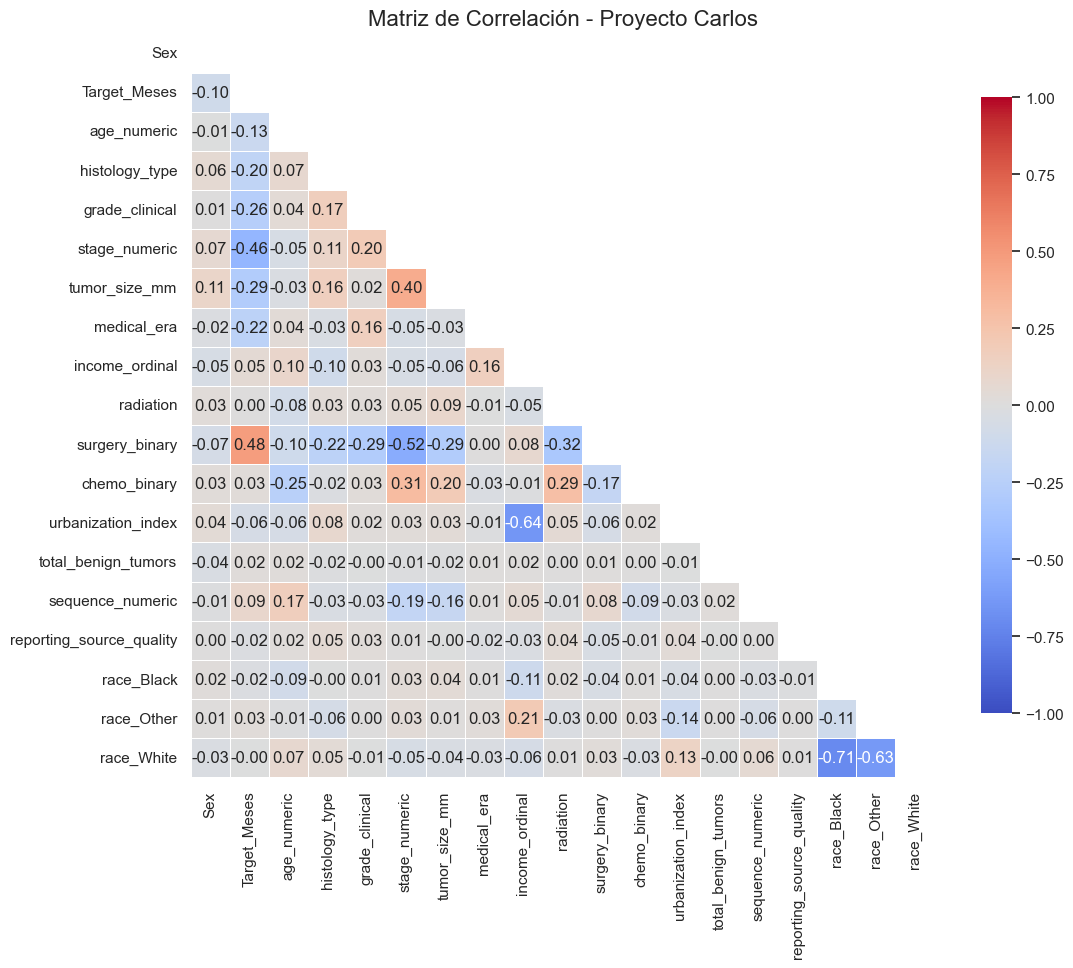

In [122]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Calcular la matriz de correlación (asumiendo que tu df se llama 'df')
# Usamos el método de Pearson por defecto para relaciones lineales
corr_matrix = df.corr()

# 2. Configurar el estilo y el tamaño de la figura
plt.figure(figsize=(12, 10))
sns.set_theme(style="white")

# 3. Crear una máscara para la mitad superior (opcional, pero muy profesional)
# Esto evita ver la misma correlación dos veces (espejo)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# 4. Dibujar el heatmap
heatmap = sns.heatmap(
    corr_matrix, 
    mask=mask, 
    annot=True,           # Muestra los números dentro de los cuadros
    fmt=".2f",            # Dos decimales
    cmap='coolwarm',      # Escala de colores (rojo positivo, azul negativo)
    vmin=-1, vmax=1,      # Asegura que la escala siempre sea de -1 a 1
    center=0,
    square=True,          # Cuadros perfectamente cuadrados
    linewidths=.5, 
    cbar_kws={"shrink": .8}
)

plt.title('Matriz de Correlación - Proyecto Carlos', fontsize=16)
plt.show()

## Split

In [123]:
df.columns

Index(['Sex', 'Target_Meses', 'age_numeric', 'histology_type',
       'grade_clinical', 'stage_numeric', 'tumor_size_mm', 'medical_era',
       'income_ordinal', 'radiation', 'surgery_binary', 'chemo_binary',
       'urbanization_index', 'total_benign_tumors', 'sequence_numeric',
       'reporting_source_quality', 'race_Black', 'race_Other', 'race_White'],
      dtype='object')

In [124]:
# # 1. Definir X e y
# X = df.drop(['Target_Meses', 'urbanization_index'], axis=1)
# y = df['Target_Meses']

# # 2. Split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # 3. Modelo con parámetros para evitar sobreajuste
# regressor = xgb.XGBRegressor(
#     n_estimators=250,
#     learning_rate=0.03,
#     enable_categorical=True, # <--- AQUÍ LE DICES QUE MANEJE LAS CATEGORÍAS
#     max_depth=8,
#     objective='reg:squarederror',
#     tree_method='hist',
#     random_state=42
# )

# regressor.fit(X_train, y_train, eval_set=[(X_test, y_test)])

In [125]:
# ESTTE FUNCIONA BIEN 

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

X = df.drop(['Target_Meses', 'urbanization_index'], axis=1)
y = df['Target_Meses']# Extraemos los pesos

# 1. Split (ya lo tienes)
# Fíjate que ahora incluimos 'weights' después de 'y'
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2. Modelo con hiperparámetros más equilibrados para evitar sobreajuste
regressor = XGBRegressor(
    # ─── Complejidad del modelo ───────────────────────────────
    max_depth=8,               # ← bajado de 8 → menos sobreajuste
    min_child_weight=7,        # ← más exigente para crear divisiones
    gamma=0.2,                 # ← mínima ganancia para dividir (regularización)
    
    # ─── Regularización fuerte L1 y L2 ────────────────────────
    reg_alpha=1,             # L1 → promueve sparse
    reg_lambda=3,            # L2 → suaviza pesos
    
    # ─── Aleatoriedad / submuestreo ───────────────────────────
    subsample=0.80,            # 80% de las filas → buena práctica
    colsample_bytree=0.75,     # 75% de columnas → evita dependencia
    colsample_bylevel=0.9,     # opcional, pero ayuda en datasets medianos
    
    # ─── Aprendizaje lento pero estable ───────────────────────
    n_estimators=600,          # más árboles pero...
    learning_rate=0.025,       # ← muy conservador (antes 0.03)
    
    # ─── Early stopping aquí  ─────────────────
    early_stopping_rounds=40,   # ← movido al constructor

    # ─── Otros importantes ────────────────────────────────────
    objective='reg:squarederror',
    tree_method='hist',        # rápido y bueno con muchas categorías
    enable_categorical=True,
    random_state=42
)

# Entrenamiento con early stopping (muy recomendado)
regressor.fit(
    X_train, y_train,           # <-- Esto es lo que le da la importancia extra
    eval_set=[(X_test, y_test)],
    verbose=20
)

[0]	validation_0-rmse:20.03399
[20]	validation_0-rmse:16.97791
[40]	validation_0-rmse:15.41868
[60]	validation_0-rmse:14.68432
[80]	validation_0-rmse:14.31653
[100]	validation_0-rmse:14.14285
[120]	validation_0-rmse:14.04369
[140]	validation_0-rmse:13.99387
[160]	validation_0-rmse:13.96650
[180]	validation_0-rmse:13.95090
[200]	validation_0-rmse:13.94168
[220]	validation_0-rmse:13.93604
[240]	validation_0-rmse:13.93288
[260]	validation_0-rmse:13.93085
[280]	validation_0-rmse:13.92935
[300]	validation_0-rmse:13.92843
[320]	validation_0-rmse:13.92799
[340]	validation_0-rmse:13.92762
[360]	validation_0-rmse:13.92684
[380]	validation_0-rmse:13.92681
[400]	validation_0-rmse:13.92681
[412]	validation_0-rmse:13.92701


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,0.9
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.75
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",40
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,True
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes fro

In [126]:
# Realizar predicciones sobre el set de prueba
y_pred = regressor.predict(X_test)

# Calcular métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"--- Métricas del Modelo ---")
print(f"MAE (Error Absoluto Medio): {mae:.2f} meses")
print(f"RMSE (Error Cuadrático Medio): {rmse:.2f} meses")
print(f"R² (Coeficiente de Determinación): {r2:.4f}")

--- Métricas del Modelo ---
MAE (Error Absoluto Medio): 10.20 meses
RMSE (Error Cuadrático Medio): 13.93 meses
R² (Coeficiente de Determinación): 0.5288


In [127]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from scipy.stats import uniform, randint

# 1. Definimos los rangos de búsqueda (Distribuciones)
param_dist = {
    'max_depth': randint(5, 10),                 # Alrededor de tu profundidad 8
    'learning_rate': uniform(0.01, 0.05),        # Alrededor de tu 0.025
    'n_estimators': randint(500, 800),           # Alrededor de tus 600
    'min_child_weight': randint(3, 10),
    'gamma': uniform(0, 0.3),
    'subsample': uniform(0.7, 0.2),              # Entre 0.7 y 0.9
    'colsample_bytree': uniform(0.6, 0.3),       # Entre 0.6 y 0.9
    'reg_alpha': uniform(0, 2),
    'reg_lambda': uniform(1, 4)
}

# 2. Configuración del modelo base
xgb_base = XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',
    enable_categorical=True,
    random_state=42
)

# 3. Configuración de la búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=40,                                   # 40 intentos inteligentes
    cv=3,                                        # Cross-validation de 3 pliegues
    scoring='neg_mean_absolute_error',           # Queremos bajar el MAE
    verbose=2,
    random_state=42,
    n_jobs=-1                                    # Usa todos los procesadores
)

# 4. Entrenamiento (Pasamos los pesos para mantener tu prioridad clínica)
print("Iniciando búsqueda de hiperparámetros...")
random_search.fit(X_train, y_train)

# 5. Resultados
best_model = random_search.best_estimator_
print("\n--- Mejores Hiperparámetros ---")
print(random_search.best_params_)

Iniciando búsqueda de hiperparámetros...
Fitting 3 folds for each of 40 candidates, totalling 120 fits

--- Mejores Hiperparámetros ---
{'colsample_bytree': np.float64(0.8550115733369398), 'gamma': np.float64(0.134835202241461), 'learning_rate': np.float64(0.014770505824520566), 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 671, 'reg_alpha': np.float64(1.2751149427104262), 'reg_lambda': np.float64(4.548850970305306), 'subsample': np.float64(0.7944429850323899)}


In [128]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Extraemos el MEJOR MODELO ya entrenado (esto es más directo)
# random_search.best_estimator_ ya es el modelo con los mejores parámetros y entrenado
final_model = random_search.best_estimator_

# NOTA: No necesitas volver a hacer .fit() si usas best_estimator_, 
# pero si quieres hacerlo para asegurar el eval_set, se hace así:
final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# 2. Realizamos predicciones
y_pred = final_model.predict(X_test)

# 3. Cálculo de métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# 4. Métricas Ponderadas (Las importantes para tu objetivo de <1 año y >20 meses)
mae_w = mean_absolute_error(y_test, y_pred)

print(f"--- Métricas Estándar ---")
print(f"MAE:  {mae:.2f} meses")
print(f"RMSE: {rmse:.2f} meses")
print(f"R²:   {r2:.4f}")


--- Métricas Estándar ---
MAE:  10.18 meses
RMSE: 13.93 meses
R²:   0.5283


## Guardar mejor modelo 

In [129]:
import pickle

# Guardar
with open("../models/modelo_pulmon_final.pkl", "wb") as file:
    pickle.dump(final_model, file)

print("Modelo guardado como archivo Pickle.")

Modelo guardado como archivo Pickle.


In [130]:
# # Calcular métricas ponderadas
# mae_weighted = mean_absolute_error(y_test, y_pred, sample_weight=w_test)
# r2_weighted = r2_score(y_test, y_pred, sample_weight=w_test)

# print(f"--- Métricas Ponderadas (Reflejan el peso 10x) ---")
# print(f"MAE Ponderado: {mae_weighted:.2f} meses")
# print(f"R² Ponderado: {r2_weighted:.4f}")

> -  El R2 ponderado significa que el modelo caputa mejor la variabilidad de los pacientes con mayor probailidad de superviviencia

In [131]:
# # Crear máscaras para separar los grupos
# mask_largo = y_test >= 20
# mask_corto = y_test < 20

# # MAE para sobrevivientes largos
# mae_largo = mean_absolute_error(y_test[mask_largo], y_pred[mask_largo])
# # MAE para sobrevivientes cortos
# mae_corto = mean_absolute_error(y_test[mask_corto], y_pred[mask_corto])

# print(f"--- Análisis por Segmento ---")
# print(f"MAE en pacientes >= 20 meses: {mae_largo:.2f} meses")
# print(f"MAE en pacientes < 20 meses: {mae_corto:.2f} meses")

In [132]:
df.shape

(458007, 19)

# GUARDAR EL MEJOR MODELO

In [133]:
# import joblib

# # Guardar el modelo
# joblib.dump(final_model, 'mejor_modelo_carlos.joblib')

# # Para cargarlo:
# # modelo_cargado = joblib.load('mejor_modelo_carlos.joblib')

## ENTRENAMIENTO SIN LA ERA 3, 2018-2022

In [134]:
# # Filtramos para quedarnos solo con pacientes con seguimiento de largo plazo
# # Era 1 y 2 tienen datos históricos más erass.
# df_eras = df[df['medical_era'].isin([1, 2])].copy()

# print(f"Registros originales: {len(df)}")
# print(f"Registros tras eliminar Era 3: {len(df_eras)}")

## Variable AGE para df_eras

In [135]:
# import pandas as pd

# # Definir los cortes por décadas (de 0 a 100+ años)
# bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 110]
# labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] # Representan las décadas

# # Crear la nueva variable de década
# df_eras['age_decade'] = pd.cut(df_eras['age_numeric'], bins=bins, labels=labels, right=False)

# # Convertir a tipo entero (importante para XGBoost)
# df_eras['age_decade'] = df_eras['age_decade'].astype(int)

# # Opcional: Podemos mantener la edad numérica original o eliminarla. 
# # A veces dejar ambas ayuda al modelo a ver el detalle y la tendencia general.
# print(df_eras[['age_numeric', 'age_decade']].head())

Split con eras

In [136]:
# # 1. Definir X e y para el set eras
# X_eras = df_eras.drop('Target_Meses', axis=1)
# y_eras = df_eras['Target_Meses']

# # 2. Split
# X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
#     X_eras, y_eras, test_size=0.2, random_state=42
# )

# # 3. Modelo XGBoost de alta capacidad
# regressor_eras = xgb.XGBRegressor(
#     n_estimators=2000,
#     learning_rate=0.03,
#     max_depth=12,
#     tree_method='hist',
#     random_state=42
# )

# # 4. Fit con Early Stopping
# regressor_eras.fit(
#     X_train_m, y_train_m, 
#     eval_set=[(X_test_m, y_test_m)],
#     verbose=100
# )

In [137]:
# # Realizar predicciones sobre el set de prueba
# y_pred = regressor_eras.predict(X_test)

# # Calcular métricas
# mae = mean_absolute_error(y_test, y_pred)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# r2 = r2_score(y_test, y_pred)

# print(f"--- Métricas del Modelo ---")
# print(f"MAE (Error Absoluto Medio): {mae:.2f} meses")
# print(f"RMSE (Error Cuadrático Medio): {rmse:.2f} meses")
# print(f"R² (Coeficiente de Determinación): {r2:.4f}")

## Modelo BASE, HIPERPARAMETRIZACIÓN

In [138]:
# import xgboost as xgb
# from sklearn.model_selection import RandomizedSearchCV

# # 1. Configuración de alto rendimiento para CPU (AMD compatible)
# xgb_reg = xgb.XGBRegressor(
#     objective='reg:squarederror', 
#     tree_method='hist',           
#     device='cpu',                 # Estabilidad total en Windows/AMD
#     n_jobs=4,                     # Deja algunos hilos libres para que el sistema no se congele
#     random_state=42
# )

# param_dist = {
#     'n_estimators': [1000, 2000], 
#     'max_depth': [7, 8, 9, 10],   # Rangos más seguros para evitar Memory Error
#     'learning_rate': [0.01, 0.03, 0.05],
#     'subsample': [0.7, 0.8, 0.9],
#     'colsample_bytree': [0.7, 0.8],
#     'gamma': [0.1, 0.5, 1]        # Ayuda a que el R2 no se infle artificialmente
# }

# random_search = RandomizedSearchCV(
#     estimator=xgb_reg,
#     param_distributions=param_dist,
#     n_iter=10,                    # 10 iteraciones * 3 folds = 30 entrenamientos
#     scoring='neg_mean_absolute_error',
#     cv=3,
#     verbose=3,
#     n_jobs=-1,                    # Paraleliza la búsqueda de parámetros
#     random_state=42
# )

# # 2. Ejecutar (Asegúrate de que X_train no tenga las columnas 'object')
# random_search.fit(X_train, y_train)

# print(f"Mejor MAE encontrado: {-random_search.best_score_}")
# print(f"Mejores Parámetros: {random_search.best_params_}")

## Guarda el mejor modelo

In [139]:
# # Extraemos el mejor modelo de la búsqueda
# mejor_modelo2 = random_search.best_estimator_

# # Guardar en formato JSON (recomendado para XGBoost moderno)
# mejor_modelo2.save_model('../models/mejormodelo_xgb_supervivencia2.json')

In [140]:
# from sklearn.metrics import mean_absolute_error, r2_score
# import numpy as np

# # Realizar predicciones
# y_pred = mejor_modelo2.predict(X_test)

# # Calcular métricas
# mae = mean_absolute_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"--- RENDIMIENTO DEL MODELO ---")
# print(f"Error Promedio (MAE): {mae:.2f} meses")
# print(f"Precisión (R2 Score): {r2:.4f}")